In [1]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [2]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

In [3]:
game = Gridworld(size=4, mode='static')

In [4]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [5]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [6]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

epochs = 1000
losses = [] #A
w, h = 14, 50000
matrix = [[0 for x in range(w)] for y in range(h)] 
t, p = 17, 50000
matrix_2 = [[0 for x in range(t)] for y in range(p)] 
counter = 0
for i in range(epochs): #B
    game = Gridworld(size=4, mode='static') #C
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D
    state1 = torch.from_numpy(state_).float() #E
    status = 1 #F
    while(status == 1): #G
        matrix[counter][5] = epsilon 
        matrix[counter][0] = i + 1
        matrix[counter][1] = (str(game.board.components['Player'].pos))
        matrix[counter][11] = (str(game.board.components['Pit'].pos))
        matrix[counter][12] = (str(game.board.components['Goal'].pos))
        matrix[counter][13] = (str(game.board.components['Wall'].pos))
        
        matrix_2[counter][0] = str(round(list(model.parameters())[5][0].item(),6)) + "/ "
        matrix_2[counter][1] = str(round(list(model.parameters())[5][1].item(),6)) + "/ "
        matrix_2[counter][2] = str(round(list(model.parameters())[5][2].item(),6)) + "/ "
        matrix_2[counter][3] = str(round(list(model.parameters())[5][3].item(),6)) + "/ "
        qval = model(state1) #H
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #I
            matrix[counter][4] = 1 
            action_ = np.random.randint(0,4)
        else:
            matrix[counter][4] = 0 
            action_ = np.argmax(qval_)
        action = action_set[action_] #J
        matrix[counter][6] = action 
        game.makeMove(action) #K
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #M
        matrix[counter][8] = maxQ.item()
        if reward == -1: #N
            matrix[counter][3] = -1 
            Y = reward + (gamma * maxQ)
        else:
            matrix[counter][3] = reward 
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O
        
        matrix[counter][7] = X.item()
        matrix[counter][9] = Y.item()
        loss = loss_fn(X, Y) #P
        matrix[counter][10] = loss.item()
        print(i, loss.item())
        clear_output(wait=True)
      
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        matrix[counter][2] = (str(game.board.components['Player'].pos))
        matrix_2[counter][4] = str(round(list(model.parameters())[5][0].item(),6)) + "/ "
        matrix_2[counter][5] = str(round(list(model.parameters())[5][1].item(),6)) + "/ "
        matrix_2[counter][6] = str(round(list(model.parameters())[5][2].item(),6)) + "/ "
        matrix_2[counter][7] = str(round(list(model.parameters())[5][3].item(),6)) + "/ "
        matrix_2[counter][8] = optimizer.state_dict()['state'][5]['step'].item()
        
        matrix_2[counter][9] = str(round(optimizer.state_dict()['state'][5]['exp_avg'][0].item(),6)) + "/ "
        matrix_2[counter][10] = str(round(optimizer.state_dict()['state'][5]['exp_avg'][1].item(),6)) + "/ "
        matrix_2[counter][11] = str(round(optimizer.state_dict()['state'][5]['exp_avg'][2].item(),6)) + "/ "
        matrix_2[counter][12] = str(round(optimizer.state_dict()['state'][5]['exp_avg'][3].item(),6)) + "/ "
        
        matrix_2[counter][13] = str(round(optimizer.state_dict()['state'][5]['exp_avg_sq'][0].item(),6)) + "/ "
        matrix_2[counter][14] = str(round(optimizer.state_dict()['state'][5]['exp_avg_sq'][1].item(),6)) + "/ "
        matrix_2[counter][15] = str(round(optimizer.state_dict()['state'][5]['exp_avg_sq'][2].item(),6)) + "/ "
        matrix_2[counter][16] = str(round(optimizer.state_dict()['state'][5]['exp_avg_sq'][3].item(),6)) + "/ "
        counter = counter + 1 
        if reward != -1: #Q
            status = 0
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)

999 0.12606801092624664


In [7]:
import pandas as pd
column_names = ["Model_Param_Current[0]", "Model_Param_Current[1]","Model_Param_Current[2]","Model_Param_Current[3]",
                "Model_Param_Next[0]","Model_Param_Next[1]","Model_Param_Next[2]","Model_Param_Next[3]", "Step", 
                "Exp_AVG[0]", "Exp_AVG[1]", "Exp_AVG[2]", "Exp_AVG[3]", 
                "Exp_AVG_SQ[0]", "Exp_AVG_SQ[1]", "Exp_AVG_SQ[2]", "Exp_AVG_SQ[3]"]

df = pd.DataFrame(matrix_2, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]

In [8]:
pd.set_option('max_colwidth', 8000)
sliced_df = pd.concat([df.head(10), df.tail(10)])


In [9]:
mapping = {'Model_Param_Current[0]': 'Current_Model_Parameters', 'Model_Param_Current[1]': 'Current_Model_Parameters',
           'Model_Param_Current[2]': 'Current_Model_Parameters', 'Model_Param_Current[3]': 'Current_Model_Parameters',
           'Model_Param_Next[0]': 'Next_Model_Parameters', 'Model_Param_Next[1]': 'Next_Model_Parameters',
           'Model_Param_Next[2]': 'Next_Model_Parameters', 'Model_Param_Next[3]': 'Next_Model_Parameters',   
           'Exp_AVG[0]': 'Exp_AVG', 'Exp_AVG[1]': 'Exp_AVG',
           'Exp_AVG[2]': 'Exp_AVG', 'Exp_AVG[3]': 'Exp_AVG',
           'Exp_AVG_SQ[0]': 'Exp_AVG_SQ', 'Exp_AVG_SQ[1]': 'Exp_AVG_SQ',
           'Exp_AVG_SQ[2]': 'Exp_AVG_SQ', 'Exp_AVG_SQ[3]': 'Exp_AVG_SQ'
          }
sliced_df = sliced_df.set_index('Step').groupby(mapping, axis = 1).sum()
  
sliced_df.reset_index(level = 0)

,Step,Current_Model_Parameters,Exp_AVG,Exp_AVG_SQ,Next_Model_Parameters
0,1.0,0.096932/ 0.050731/ -0.014723/ 0.067057/,0.0/ 0.0/ 0.184655/ 0.0/,0.0/ 0.0/ 0.00341/ 0.0/,0.096932/ 0.050731/ -0.015723/ 0.067057/
1,2.0,0.096932/ 0.050731/ -0.015723/ 0.067057/,0.0/ 0.0/ 0.166189/ 0.202155/,0.0/ 0.0/ 0.003406/ 0.004087/,0.096932/ 0.050731/ -0.016393/ 0.066313/
2,3.0,0.096932/ 0.050731/ -0.016393/ 0.066313/,0.0/ 0.196437/ 0.14957/ 0.181939/,0.0/ 0.003859/ 0.003403/ 0.004083/,0.096932/ 0.050093/ -0.016911/ 0.065737/
3,4.0,0.096932/ 0.050093/ -0.016911/ 0.065737/,0.0/ 0.176793/ 0.134613/ 0.352214/,0.0/ 0.003855/ 0.0034/ 0.007631/,0.096932/ 0.049569/ -0.017335/ 0.064996/
4,5.0,0.096932/ 0.049569/ -0.017335/ 0.064996/,0.205042/ 0.159114/ 0.121152/ 0.316993/,0.004204/ 0.003851/ 0.003396/ 0.007623/,0.096387/ 0.049127/ -0.017694/ 0.06437/
5,6.0,0.096387/ 0.049127/ -0.017694/ 0.06437/,0.184537/ 0.143202/ 0.277898/ 0.285294/,0.0042/ 0.003847/ 0.006244/ 0.007615/,0.095917/ 0.048746/ -0.018274/ 0.06383/
6,7.0,0.095917/ 0.048746/ -0.018274/ 0.06383/,0.36768/ 0.128882/ 0.250108/ 0.256764/,0.00826/ 0.003843/ 0.006238/ 0.007608/,0.095269/ 0.048413/ -0.018781/ 0.063359/
7,8.0,0.095269/ 0.048413/ -0.018781/ 0.063359/,0.330912/ 0.115994/ 0.225097/ 0.41377/,0.008252/ 0.003839/ 0.006232/ 0.010937/,0.094698/ 0.048119/ -0.019229/ 0.062739/
8,9.0,0.094698/ 0.048119/ -0.019229/ 0.062739/,0.297821/ 0.299405/ 0.202588/ 0.372393/,0.008243/ 0.007639/ 0.006225/ 0.010926/,0.094191/ 0.04759/ -0.019625/ 0.062188/
9,10.0,0.094191/ 0.04759/ -0.019625/ 0.062188/,0.268038/ 0.269464/ 0.350656/ 0.335154/,0.008235/ 0.007631/ 0.009053/ 0.010915/,0.093738/ 0.047117/ -0.02019/ 0.061697/


In [10]:
x  = 0.015615644
round(x,6)

0.015616

In [11]:
test = torch.nn.Sequential()
print(test)

Sequential()


In [12]:
optimizer.state_dict()

{'state': {0: {'step': tensor(19151.),
   'exp_avg': tensor([[ 5.3743e-05,  2.6938e-05, -6.2751e-04,  ..., -7.7618e-05,
            -1.0284e-04,  3.8598e-05],
           [-1.6744e-04, -2.2417e-04, -3.1870e-04,  ..., -7.0689e-05,
            -9.1860e-05, -1.4974e-04],
           [ 9.7073e-04, -9.7516e-04,  7.0895e-04,  ..., -6.2829e-04,
            -7.3704e-05, -2.0626e-03],
           ...,
           [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
             5.6052e-45,  5.6052e-45],
           [-1.6986e-04, -1.7407e-03,  2.9538e-06,  ..., -3.2009e-04,
            -1.3524e-03, -6.7324e-04],
           [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
             5.6052e-45,  5.6052e-45]]),
   'exp_avg_sq': tensor([[1.2511e-05, 1.3907e-05, 2.2289e-03,  ..., 1.2727e-05, 1.1030e-05,
            1.8423e-05],
           [6.7696e-05, 8.2191e-05, 3.0306e-03,  ..., 5.8333e-05, 5.3418e-05,
            6.7566e-05],
           [2.9182e-05, 3.0917e-05, 7.4569e-04,  ..., 2.81

In [13]:
optimizer.zero_grad()
optimizer.state_dict()

{'state': {0: {'step': tensor(19151.),
   'exp_avg': tensor([[ 5.3743e-05,  2.6938e-05, -6.2751e-04,  ..., -7.7618e-05,
            -1.0284e-04,  3.8598e-05],
           [-1.6744e-04, -2.2417e-04, -3.1870e-04,  ..., -7.0689e-05,
            -9.1860e-05, -1.4974e-04],
           [ 9.7073e-04, -9.7516e-04,  7.0895e-04,  ..., -6.2829e-04,
            -7.3704e-05, -2.0626e-03],
           ...,
           [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
             5.6052e-45,  5.6052e-45],
           [-1.6986e-04, -1.7407e-03,  2.9538e-06,  ..., -3.2009e-04,
            -1.3524e-03, -6.7324e-04],
           [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
             5.6052e-45,  5.6052e-45]]),
   'exp_avg_sq': tensor([[1.2511e-05, 1.3907e-05, 2.2289e-03,  ..., 1.2727e-05, 1.1030e-05,
            1.8423e-05],
           [6.7696e-05, 8.2191e-05, 3.0306e-03,  ..., 5.8333e-05, 5.3418e-05,
            6.7566e-05],
           [2.9182e-05, 3.0917e-05, 7.4569e-04,  ..., 2.81

In [14]:
params = list(model.parameters())
params[5]

Parameter containing:
tensor([0.2594, 0.0542, 0.0914, 0.0028], requires_grad=True)

In [15]:
params[0].size()

torch.Size([150, 64])

In [16]:
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

In [17]:
res = dict((k, optimizer.state_dict()[k]) for k in ["param_groups"]
           if k in optimizer.state_dict())
res

{'param_groups': [{'lr': 0.001,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': False,
   'params': [0, 1, 2, 3, 4, 5]}]}

In [18]:
dic = optimizer.state_dict()
dic['state'][5]

{'step': tensor(19151.),
 'exp_avg': tensor([-9.6303e-02,  3.5278e-02,  5.3713e-02,  3.0165e-05]),
 'exp_avg_sq': tensor([0.1159, 0.0496, 0.1206, 0.0120])}

Text(0, 0.5, 'Loss')

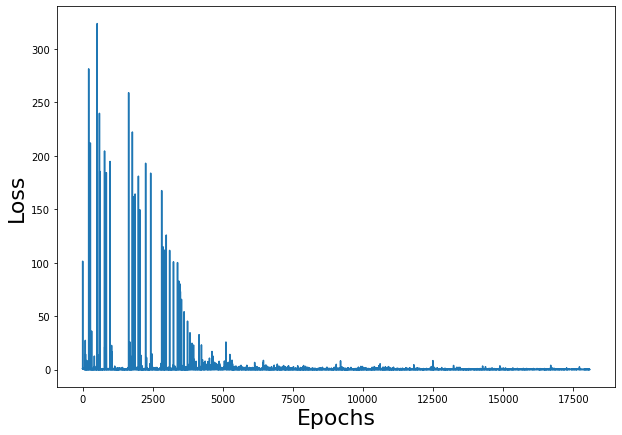

In [22]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [23]:
import pandas as pd
column_names = ["Epochs","Cuttent_State", "Next_State", "Reward","Epsilon_Boolean", "Epsilon", "Action",
                "Current_Q_Value", "Next_Q_Value","Reawrd_Plus_Next_Q_Value", "Loss",
               "Pit_Position", "Goal_Position", "Wall_Position"]

df = pd.DataFrame(matrix, columns = column_names)

In [24]:
df = df.loc[(df != 0).any(axis=1)]

In [25]:
df

,Epochs,Cuttent_State,Next_State,Reward,Epsilon_Boolean,Epsilon,Action,Current_Q_Value,Next_Q_Value,Reawrd_Plus_Next_Q_Value,Loss,Pit_Position,Goal_Position,Wall_Position
0,1,"(0, 3)","(0, 3)",-1,1,1.0,u,-0.000187,0.116006,-0.895595,0.801755,"(0, 1)","(0, 0)","(1, 1)"
1,1,"(0, 3)","(0, 3)",-1,1,1.0,u,-0.048032,0.113065,-0.898242,0.722857,"(0, 1)","(0, 0)","(1, 1)"
2,1,"(0, 3)","(0, 2)",-1,1,1.0,l,0.108714,0.102920,-0.907372,1.032431,"(0, 1)","(0, 0)","(1, 1)"
3,1,"(0, 2)","(0, 2)",-1,1,1.0,u,-0.113622,0.080253,-0.927772,0.662841,"(0, 1)","(0, 0)","(1, 1)"
4,1,"(0, 2)","(0, 1)",-10,1,1.0,l,0.064879,0.057142,-10.000000,101.301796,"(0, 1)","(0, 0)","(1, 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18085,1000,"(2, 2)","(2, 1)",-1,0,0.1,l,4.652837,6.327810,4.695029,0.001780,"(0, 1)","(0, 0)","(1, 1)"
18086,1000,"(2, 1)","(2, 0)",-1,0,0.1,l,6.328544,7.933452,6.140107,0.035509,"(0, 1)","(0, 0)","(1, 1)"
18087,1000,"(2, 0)","(2, 0)",-1,1,0.1,l,6.430224,7.819659,6.037693,0.154081,"(0, 1)","(0, 0)","(1, 1)"
18088,1000,"(2, 0)","(1, 0)",-1,0,0.1,u,7.793209,10.012731,8.011457,0.047632,"(0, 1)","(0, 0)","(1, 1)"


In [26]:
pd.set_option('max_colwidth', 2000)
sliced_df = pd.concat([df.head(10), df.tail(10)])
sliced_df

,Epochs,Cuttent_State,Next_State,Reward,Epsilon_Boolean,Epsilon,Action,Current_Q_Value,Next_Q_Value,Reawrd_Plus_Next_Q_Value,Loss,Pit_Position,Goal_Position,Wall_Position
0,1,"(0, 3)","(0, 3)",-1,1,1.000,u,-0.000187,0.116006,-0.895595,0.801755,"(0, 1)","(0, 0)","(1, 1)"
1,1,"(0, 3)","(0, 3)",-1,1,1.000,u,-0.048032,0.113065,-0.898242,0.722857,"(0, 1)","(0, 0)","(1, 1)"
2,1,"(0, 3)","(0, 2)",-1,1,1.000,l,0.108714,0.102920,-0.907372,1.032431,"(0, 1)","(0, 0)","(1, 1)"
3,1,"(0, 2)","(0, 2)",-1,1,1.000,u,-0.113622,0.080253,-0.927772,0.662841,"(0, 1)","(0, 0)","(1, 1)"
4,1,"(0, 2)","(0, 1)",-10,1,1.000,l,0.064879,0.057142,-10.000000,101.301796,"(0, 1)","(0, 0)","(1, 1)"
5,2,"(0, 3)","(0, 3)",-1,1,0.999,r,-0.022890,0.046329,-0.958304,0.875000,"(0, 1)","(0, 0)","(1, 1)"
6,2,"(0, 3)","(0, 2)",-1,1,0.999,l,0.028252,0.022907,-0.979384,1.015331,"(0, 1)","(0, 0)","(1, 1)"
7,2,"(0, 2)","(0, 3)",-1,1,0.999,r,-0.037546,0.040254,-0.963772,0.857894,"(0, 1)","(0, 0)","(1, 1)"
8,2,"(0, 3)","(0, 3)",-1,1,0.999,u,-0.217513,0.045673,-0.958895,0.549647,"(0, 1)","(0, 0)","(1, 1)"
9,2,"(0, 3)","(1, 3)",-1,1,0.999,d,0.047482,0.029722,-0.973250,1.041894,"(0, 1)","(0, 0)","(1, 1)"


In [27]:
    i = 0
    test_game = Gridworld(mode="random")
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    w, h = 8, 100
    matrix = [[0 for x in range(w)] for y in range(h)] 
    counter = 0
    while(status == 1): #A
        matrix[counter][0] = (str(test_game.board.components['Player'].pos))
        matrix[counter][5] = (str(test_game.board.components['Pit'].pos))
        matrix[counter][6] = (str(test_game.board.components['Goal'].pos))
        matrix[counter][7] = (str(test_game.board.components['Wall'].pos))
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        matrix[counter][2] = action 
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        matrix[counter][1] = (str(test_game.board.components['Player'].pos))
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        matrix[counter][3] = reward
        matrix[counter][4] = i
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        counter = counter + 1 
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False

Initial State:
[[' ' ' ' ' ' 'W']
 [' ' ' ' '-' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']]
Move #: 0; Taking action: l
[[' ' ' ' ' ' 'W']
 [' ' ' ' '-' '+']
 [' ' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' 'W']
 [' ' ' ' '-' '+']
 [' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[[' ' ' ' ' ' 'W']
 [' ' ' ' '-' '+']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: u
[[' ' ' ' ' ' 'W']
 ['P' ' ' '-' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: u
[['P' ' ' ' ' 'W']
 [' ' ' ' '-' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: l
[['P' ' ' ' ' 'W']
 [' ' ' ' '-' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: l
[['P' ' ' ' ' 'W']
 [' ' ' ' '-' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 7; Taking action: l
[['P' ' ' ' ' 'W']
 [' ' ' ' '-' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 8; Taking action: l
[['P' ' ' ' ' 'W']
 [' ' ' ' '-' '+']
 [

In [28]:
import pandas as pd
column_names = ["Cuttent_State", "Next_State", "Action", "Reward",
                "Step_Number", "Pit_Position", "Goal_Position", "Wall_Position"]

df = pd.DataFrame(matrix, columns = column_names)

In [29]:
df = df.loc[(df != 0).any(axis=1)]
df

,Cuttent_State,Next_State,Action,Reward,Step_Number,Pit_Position,Goal_Position,Wall_Position
0,"(3, 2)","(3, 1)",l,-1,0,"(1, 2)","(1, 3)","(0, 3)"
1,"(3, 1)","(3, 0)",l,-1,1,"(1, 2)","(1, 3)","(0, 3)"
2,"(3, 0)","(2, 0)",u,-1,2,"(1, 2)","(1, 3)","(0, 3)"
3,"(2, 0)","(1, 0)",u,-1,3,"(1, 2)","(1, 3)","(0, 3)"
4,"(1, 0)","(0, 0)",u,-1,4,"(1, 2)","(1, 3)","(0, 3)"
5,"(0, 0)","(0, 0)",l,-1,5,"(1, 2)","(1, 3)","(0, 3)"
6,"(0, 0)","(0, 0)",l,-1,6,"(1, 2)","(1, 3)","(0, 3)"
7,"(0, 0)","(0, 0)",l,-1,7,"(1, 2)","(1, 3)","(0, 3)"
8,"(0, 0)","(0, 0)",l,-1,8,"(1, 2)","(1, 3)","(0, 3)"
9,"(0, 0)","(0, 0)",l,-1,9,"(1, 2)","(1, 3)","(0, 3)"


In [30]:
list2 = list(model.parameters())
list2

[Parameter containing:
 tensor([[ 0.0566, -0.0090,  0.2082,  ...,  0.1257,  0.1107, -0.0874],
         [ 0.0674, -0.0438,  0.4082,  ...,  0.0487,  0.0546,  0.1223],
         [ 0.0510, -0.0480,  0.0485,  ...,  0.1176,  0.0485, -0.0436],
         ...,
         [-0.1457,  0.1363,  0.2590,  ...,  0.0953,  0.0166, -0.0859],
         [-0.0985, -0.0198,  0.0019,  ...,  0.0658, -0.1309,  0.0747],
         [-0.0007,  0.0607, -0.0692,  ..., -0.1380,  0.0399, -0.0846]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.1032, -0.0326, -0.0789,  0.0052,  0.0315,  0.0839, -0.0387, -0.0020,
          0.1209, -0.0893,  0.0004, -0.1082,  0.0501,  0.0072, -0.0704,  0.0166,
         -0.1189, -0.1213, -0.1027,  0.0978, -0.1136, -0.0837,  0.0594,  0.2284,
          0.0573, -0.1237,  0.0825, -0.0254,  0.1600, -0.0687, -0.0489,  0.1236,
         -0.0549,  0.0536,  0.1003,  0.1195, -0.0541,  0.0702, -0.0598,  0.2360,
          0.0253, -0.0499,  0.0516,  0.0651,  0.0579,  0.0507, -0.0264,  0.0475